In [2]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

<p>
<span style="color:blue">
> Importing data
</span>
</p>

In [3]:
dataset=pd.read_excel("loan.xlsx")

## Data Cleaning

<p>
<span style="color:blue">
> Removed all empty columns ( these are the columns with personal data of the borrowers. These are not disclosed by the company. so we dropped them)<br>
> Target variable(Borrower is a Loan defaulter) - encoded to 0 or 1<br>
</span>
</p>

In [4]:
dataset = dataset.iloc[:,2:53]          #removing empty columns

<p>
<span style="color:blue">
> some more columns were dropped in the below cell. some of them are not related to our target variable and some of them are redundant. <br>
</span>
</p>

In [5]:
del_col_names = ["emp_title","url","desc","title","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line",
                 "inq_last_6mths","mths_since_last_delinq","mths_since_last_record","mths_since_last_major_derog",
                 "collections_12_mths_ex_med","last_credit_pull_d","next_pymnt_d","last_pymnt_d","initial_list_status"] #deleting some more columns
dataset = dataset.drop(labels = del_col_names, axis = 1) 
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (39717, 33)


In [6]:
features = ['loan_amnt','funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "pub_rec", "int_rate", "open_acc",'loan_status'] #'sub_grade' #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features] #11 features with target var
loan_dataset=Final_data.dropna()
print("Current shape of dataset :",loan_dataset.shape)
loan_dataset.head()

Current shape of dataset : (38642, 11)


,loan_amnt,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,5000,5000,10+ years,24000.0,RENT,B,171.62,0,0.1065,3,Fully Paid
1,2500,2500,< 1 year,30000.0,RENT,C,119.66,0,0.1527,3,Charged Off
2,2400,2400,10+ years,12252.0,RENT,C,649.91,0,0.1596,2,Fully Paid
3,10000,10000,10+ years,49200.0,RENT,C,357.48,0,0.1349,10,Fully Paid
4,3000,3000,1 year,80000.0,RENT,B,67.79,0,0.1269,15,Current


In [7]:
bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
loan_dataset['amount_range'] = pd.cut(loan_dataset['loan_amnt'], bins, labels=slot)

In [8]:
bins = [0, .075, .10, .125, .15,.20]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
loan_dataset['intrestrate_range'] = pd.cut(loan_dataset['int_rate'], bins, labels=slot)

# univariate Analysis

In [16]:
def univariate(df,col,vartype,hue =None):
    
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.
    
    '''
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan_dataset))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

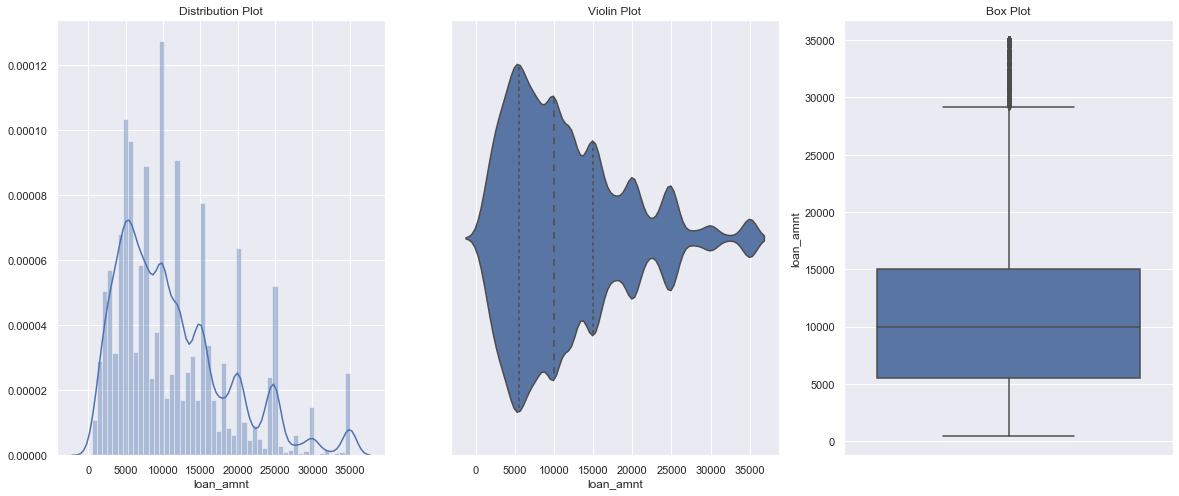

In [10]:
univariate(df=loan_dataset,col='loan_amnt',vartype=0)

 In most of the cases loan disbursed betwwen the people lies in amount 6000 to 15000

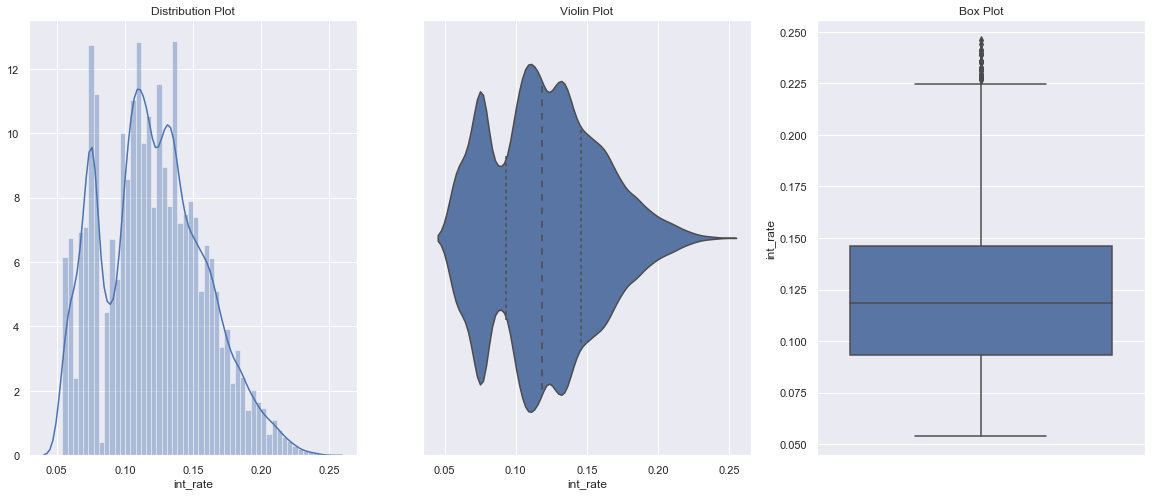

In [11]:
univariate(df=loan_dataset,col='int_rate',vartype=0)

 In most of the cases loan disbursed betwwen the people have interest rates in between 8.5% to 14.5%.

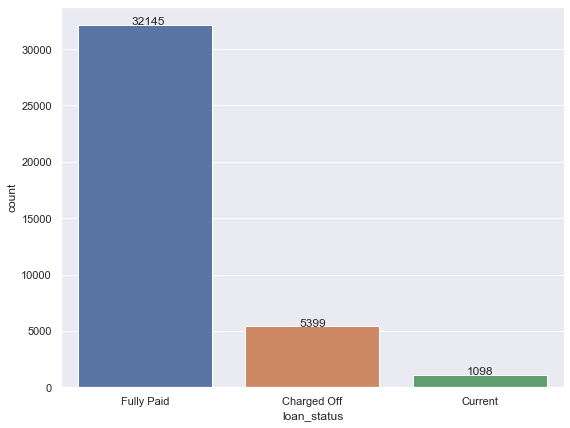

In [12]:
univariate(df=loan_dataset,col='loan_status',vartype=1)

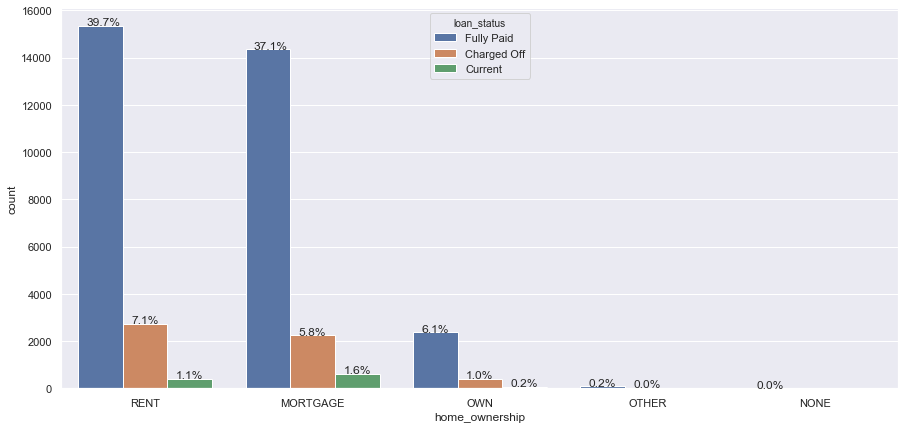

In [17]:
univariate(df=loan_dataset,col='home_ownership',vartype=1,hue='loan_status')

39.7% of People who applied for loan and fully paid are living in rented home.
37.1% of People who applied for loan and fully paid mortagaged their home.
6.1% of People who applied for loan and fully paid live in their own home.

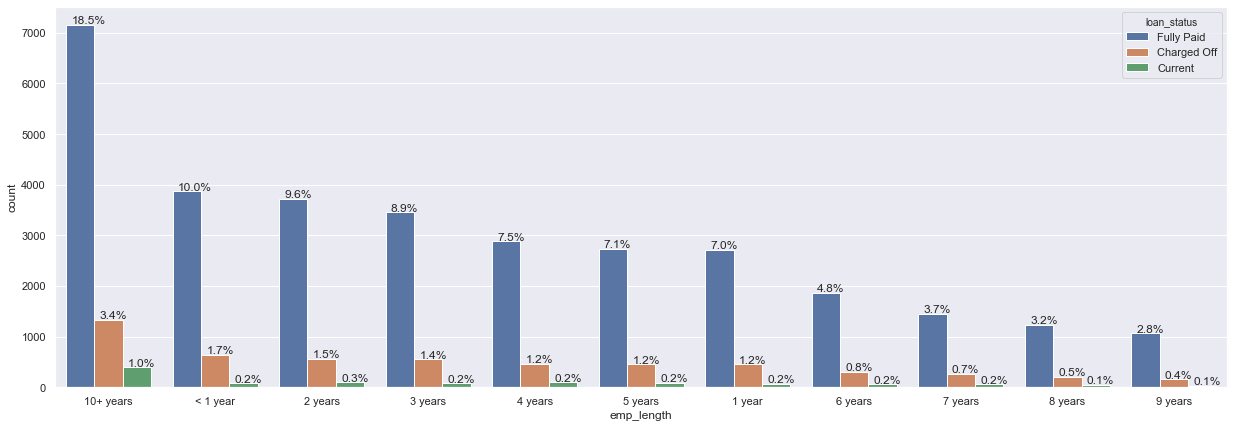

In [18]:
univariate(df=loan_dataset,col='emp_length',vartype=1,hue='loan_status')

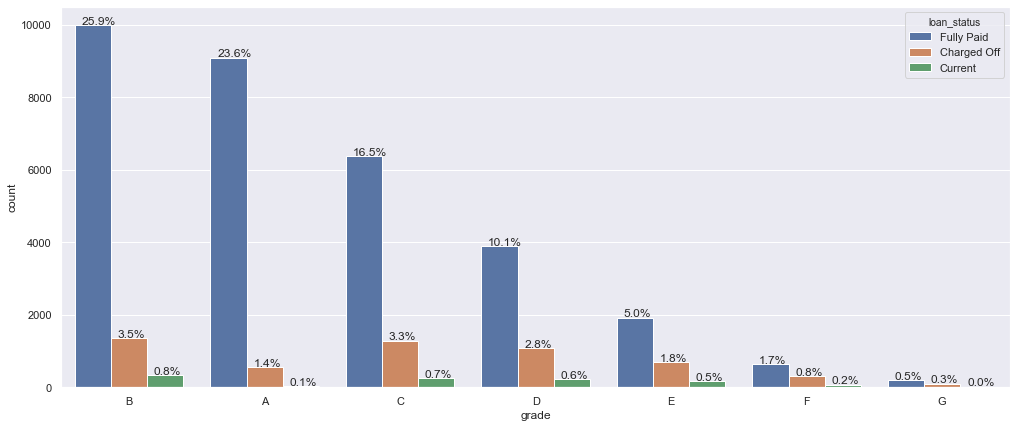

In [19]:
univariate(df=loan_dataset,col='grade',vartype=1,hue='loan_status')

In [20]:
loan_dataset.corr()

,loan_amnt,funded_amnt,annual_inc,last_pymnt_amnt,pub_rec,int_rate,open_acc
loan_amnt,1.000000,0.981393,0.268447,0.447762,-0.047820,0.307613,0.173790
funded_amnt,0.981393,1.000000,0.264129,0.452287,-0.048736,0.310837,0.172224
annual_inc,0.268447,0.264129,1.000000,0.138441,-0.015162,0.050323,0.155740
last_pymnt_amnt,0.447762,0.452287,0.138441,1.000000,-0.031723,0.157218,0.076376
pub_rec,-0.047820,-0.048736,-0.015162,-0.031723,1.000000,0.097358,0.002791
int_rate,0.307613,0.310837,0.050323,0.157218,0.097358,1.000000,0.012251
open_acc,0.173790,0.172224,0.155740,0.076376,0.002791,0.012251,1.000000


## Multivariate Analysis


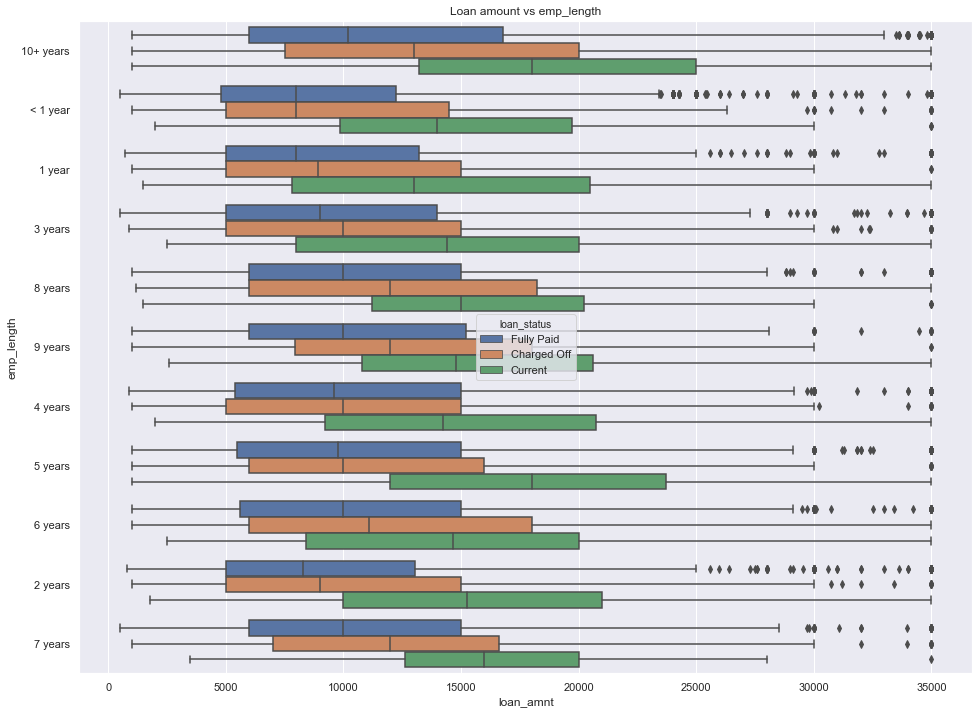

In [21]:
plt.figure(figsize=(16,12))
sns.boxplot(data =loan_dataset, x='loan_amnt', y='emp_length', hue ='loan_status')
plt.title('Loan amount vs emp_length')
plt.show()

In [22]:
incomefilter = loan_dataset["annual_inc"].quantile(0.995)
loan_dataset = loan_dataset[loan_dataset["annual_inc"] < incomefilter]

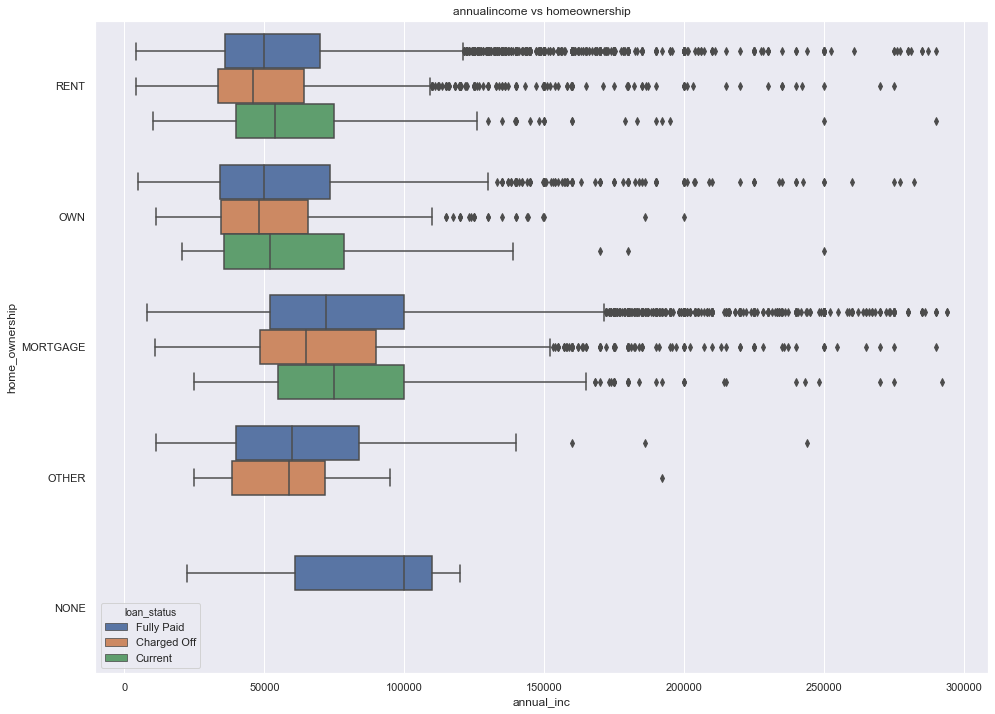

In [23]:
plt.figure(figsize=(16,12))
sns.boxplot(data =loan_dataset, x='annual_inc', y='home_ownership', hue ='loan_status')
plt.title('annualincome vs homeownership')
plt.show()